In [ ]:
!git clone https://github.com/xJenDragon/StrangerStats.git

Cloning into 'StrangerStats'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 113 (delta 55), reused 18 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 2.91 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (55/55), done.


# Stranger Stats: The Hawkins Mystery 🧪👾

# Important Installs

In [ ]:
!python /content/StrangerStats/helper/install.py
!pip install pandas

# 1. Loading the Data 📂
We’ll start by loading the datasets using our helper functions.

In [ ]:
# Add helper folder to sys.path
import sys
sys.path.append("/content/StrangerStats/helper")

# Import and reload
import data_loader as dl
import analysis as an
import viz as vz
import pandas as pd
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
importlib.reload(dl)

# Path to your Excel file
DATA_FILE = "/content/StrangerStats/data/stranger_stats.xlsx"

# Load data
monster_df = dl.load_monster_sightings(DATA_FILE)
char_df = dl.load_character_stats(DATA_FILE)
events_df = dl.load_upside_down_events(DATA_FILE)

# 2. Helpers for Data 🙋
Providing some helpers for time conversion, severity conversion, etc.

In [ ]:
# Converting Time columns to hours for easier merging
char_df["Hour"] = char_df["Time"].apply(lambda t: t.hour if pd.notnull(t) else None)
char_df = char_df.dropna(subset=["Hour"])
char_df["Hour"] = char_df["Hour"].astype(int)

events_df["Hour"] = events_df["Time"].apply(lambda t: t.hour if pd.notnull(t) else None)
events_df = events_df.dropna(subset=["Hour"])
events_df["Hour"] = events_df["Hour"].astype(int)

# Map Severity to numeric
severity_map = {"Low": 1, "Medium": 2, "High": 3}
events_df["Severity_Num"] = events_df["Severity"].map(severity_map)

# 3. The Hawkins Mystery ☎️

### Challenge 1: Which character is most likely to encounter a monster?

**Instructions:**  
- Merge the Monster Sightings and Character Stats datasets by `Day` and `Hour`.  
- Count how many times each character appears when a monster is present.  
- Sort to find the character most likely to encounter a monster.

**Hints:**  
- Use `pd.merge()` with `on=["Day","Hour"]`.  
- Use `groupby()` and `count()` to aggregate.


In [ ]:
# Merge events_df (Upside Down) with char_df on Day and Hour
merged = pd.merge(events_df, char_df, on=["Day","Hour"], suffixes=("_monster","_char"))

# Ensure Monster counts are numeric
merged["Count"] = pd.to_numeric(merged["Count"], errors="coerce")

# Drop rows with missing counts
merged = merged.dropna(subset=["Count"])

# Challenge 1 solution: average monsters encountered per character
character_encounters_solution = merged.groupby("Character")["Count"].mean().sort_values(ascending=False)

print("Average monsters encountered per character:")
print(character_encounters_solution)

Average monsters encountered per character:
Character
Mike      2.400000
Will      1.846154
Lucas     1.555556
Max       1.333333
Eleven    1.000000
Dustin    0.400000
Hopper    0.000000
Name: Count, dtype: float64


### Challenge 2: Which day/hour is the most dangerous overall?

**Instructions:**  
- Combine monster counts and Upside Down event severity.  
- Create a "danger score" (monster count × severity).  
- Identify the day/hour with the highest danger score.

**Hints:**  
- Use `groupby(["Day","Hour"]).agg(...)`.  
- Sort the results with `sort_values()`.

In [ ]:
# Map severity to numeric
severity_map = {"Low": 1, "Medium": 2, "High": 3}
events_df["Severity_Num"] = events_df["Severity"].map(severity_map)

# Drop rows with missing severity
events_df = events_df.dropna(subset=["Severity_Num"])

# Aggregate monster counts by Day from monster_df
monster_counts_by_day = monster_df.groupby("Day")["Count"].sum().reset_index()
monster_counts_by_day.rename(columns={"Count": "Monster_Count"}, inplace=True)

# Merge with events_df on Day
danger_df = events_df.merge(monster_counts_by_day, on="Day")

# Compute danger score = Monster_Count * Severity_Num
danger_df["Danger_Score"] = danger_df["Monster_Count"] * danger_df["Severity_Num"]

# Group by Day and Time to calculate average danger score
avg_danger_summary = danger_df.groupby(["Day", "Time"]).agg({"Danger_Score": "mean"}).sort_values("Danger_Score", ascending=False)

print("Top average danger day/hour:")
print(avg_danger_summary.head(10))

Top average danger day/hour:
                   Danger_Score
Day      Time                  
Thursday 19:46:00         150.0
         12:58:00         150.0
         09:02:00         150.0
         19:08:00         150.0
Saturday 13:05:00         105.0
         17:29:00         105.0
         13:32:00         105.0
Thursday 17:14:00         100.0
         12:15:00         100.0
         19:33:00         100.0


### Challenge 3: Does monster count correlate with Upside Down severity?

**Instructions:**  
- Measure correlation between monster counts and severity.
- Which monsters tend to cause more severe events?

**Hints:**  
- Use `corr()` to compute Pearson correlation.  
- Filter datasets if needed.

In [ ]:
# Step 1: Clean column names
monster_df.columns = monster_df.columns.str.strip()
events_df.columns = events_df.columns.str.strip()

# Step 2: Map severity to numeric
severity_map = {"Low": 1, "Medium": 2, "High": 3}
events_df["Severity_Num"] = events_df["Severity"].map(severity_map)
events_df = events_df.dropna(subset=["Severity_Num"])

# Step 3: Rename monster count to avoid collisions
monster_df = monster_df.rename(columns={"Count": "Monster_Count"})

# Step 4: Aggregate monster counts by Day (or any other key if needed)
daily_monster_counts = monster_df.groupby("Day")["Monster_Count"].sum().reset_index()

# Merge with events_df
merged = pd.merge(events_df, daily_monster_counts, on="Day")

# Compute Pearson correlation
correlation = merged["Monster_Count"].corr(merged["Severity_Num"])
print(f"Pearson correlation between monster count and Upside Down severity: {correlation:.2f}")

Pearson correlation between monster count and Upside Down severity: 0.02


### Challenge 4: Which monster is most likely to appear next?

**Instructions:**  
- Calculate probability of each monster appearing next.
- Use historical monster sightings.

**Hints:**  
- Use `value_counts(normalize=True)` to get probabilities.

In [ ]:
monster_probs_solution = monster_df["Monster"].value_counts(normalize=True).round(2)
print(monster_probs_solution)

Monster
Demodog        0.37
Demogorgon     0.35
Mind Flayer    0.28
Name: proportion, dtype: float64


### Challenge 5: Probability of High severity for next monster event.

**Instructions:**  
- Calculate `P(High severity | Monster).`
- Optional: filter by day or location.

**Hints:**  
- Use g`roupby("Monster")["Severity"].apply(lambda x: (x=="High").mean()).`
- Round probabilities for readability.

In [ ]:
# Map severity to numeric (optional)
severity_map = {"Low": 1, "Medium": 2, "High": 3}
events_df["Severity_Num"] = events_df["Severity"].map(severity_map)

# Drop rows with missing severity
events_df = events_df.dropna(subset=["Severity_Num"])

# Probability that the next event is High severity by monster
prob_high_by_monster = events_df.groupby("Monster")["Severity"].apply(
    lambda x: (x.eq("High").sum() + 1) / (len(x) + 2)
)

print("Probability of High severity for next Upside Down event by monster:")
print(prob_high_by_monster)

Probability of High severity for next Upside Down event by monster:
Monster
Demodog        0.041667
Demogorgon     0.960000
Mind Flayer    0.041667
Name: Severity, dtype: float64


### Challenge 6: Character activity vs monster peaks

**Instructions:**  
- Merge datasets by hour.
- Create a heatmap showing which characters are active when monsters appear.

**Hints:**  
- Use `groupby(["Hour","Character"])["Monster"].count().unstack(fill_value=0).`
- Use `sns.heatmap()` for visualization.

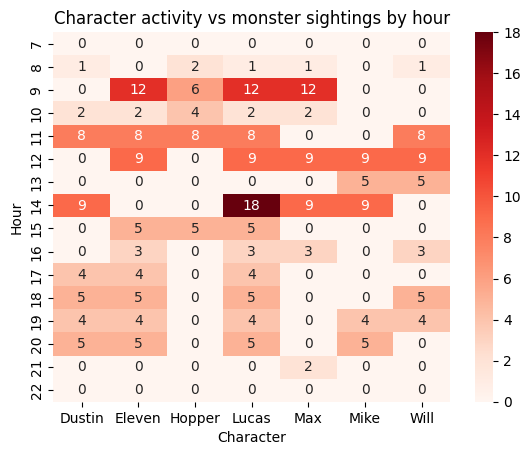

In [ ]:
heat_df_solution = pd.merge(events_df, char_df, on="Hour", suffixes=("_monster","_char"))
activity_heatmap_solution = heat_df_solution.groupby(["Hour","Character"])["Monster"].count().unstack(fill_value=0)
sns.heatmap(activity_heatmap_solution, cmap="Reds", annot=True, fmt="d")
plt.title("Character activity vs monster sightings by hour")
plt.show()